In [17]:
import os
import random
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import seaborn as sns
sns.set(style="whitegrid", font="Helvetica")
import pyactup as pau

# Set Random Seed

For reproducibility

In [18]:
random.seed(24021976)

# Log-Likelihood for ACT-R

This notebook contains tutorial on how to estimate the likelihood of an ACT-R models. The likelihood of a model $m$ with a given set of parameter values $\theta$, given the data $x$, is formally defined as 

$$L(m, \theta | x_o) = P(x = x_o | m, \theta)$$

This definition is intuitive: a model is more "likely" than another when it has a greater probability of producing the observed data.

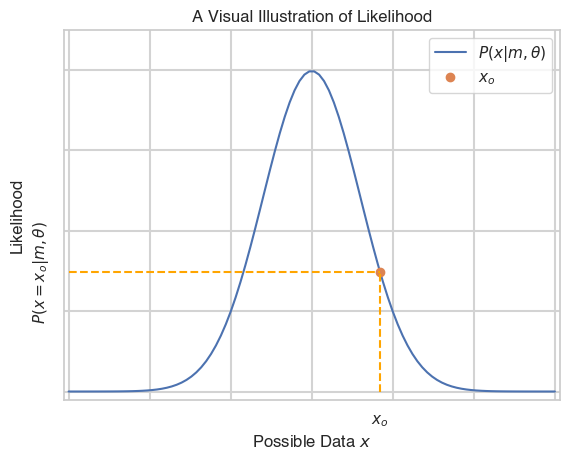

In [19]:
# Visualization of likelihood

gauss = stat.norm(0, 1)
x = np.linspace(-5, 5, 100)
y = gauss.pdf(x)
x_o = np.random.uniform(0.65, 1.5)
y_o = gauss.pdf(x_o)

# Visualize
fig = plt.figure()
ax = fig.add_subplot(111)

# Fake grid
for i in np.linspace(-5, 5, 7):
    ax.axvline(i, color='lightgrey')
for i in np.linspace(0, 0.4, 5):
    ax.axhline(i, color='lightgrey')
    
ax.plot(x, y, label=r"$P(x|m, \theta)$")
ax.plot(x_o, y_o, "o", label="$x_o$")
ax.legend()
ax.set_xlim(-5.1, 5.1)
ax.set_ylim(-0.01, 0.45)

ax.set_xlabel("Possible Data $x$")
ax.set_xticks([x_o])
ax.set_xticklabels(["$x_o$"])
ax.set_yticks([y_o])
ax.set_yticklabels([r"$P(x=x_o|m, \theta)$"], rotation=90, va="center")
ax.grid()
ax.set_ylabel("Likelihood")
ax.plot([-5, x_o], [y_o, y_o], "--", color="orange")
ax.plot([x_o, x_o], [0, y_o], "--", color="orange")
ax.set_title("A Visual Illustration of Likelihood")
plt.savefig("loglikelihood.png")
plt.show()

# Difference between Likelihood $\mathcal{L}(\theta|x)$ and Probability $P(x|\theta)$

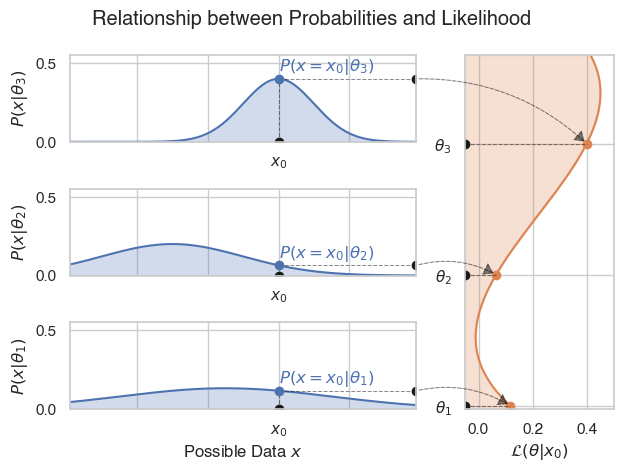

In [20]:
from scipy.stats import norm
from matplotlib import lines, patches
# Placing the plots in the plane 
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2) 
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2) 
ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=2) 
ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=3) 

fig = ax1.get_figure()
x0 = 6
x=np.linspace(0, 10, 200)

axes = [ax1, ax2, ax3]
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([2, 4, x0, 8], labels=["", "", "$x_0$", ""])
    ax.set_ylim(0, 0.55)
    ax.set_xlim(0.1, 9.9)

ax3.set_xlabel("Possible Data $x$")
ax4.set_xlabel(r"$\mathcal{L}(\theta|x_0)$")
#ax4.set_ylabel(r"Model parameters $\theta$", rotation=-90, labelpad=20)
ax4.set_ylim(0, 10)
ax4.set_xlim(-0.05, 0.5)

# Generate the data distributions

dist1 = norm(loc=6, scale=1)
dist2 = norm(loc=3, scale=2)
dist3 = norm(loc=4.5, scale=3)

dists = [dist1, dist2, dist3]

# Generate the likelihoods for x = x0
likelihoods = [dist.pdf(x0) for dist in dists]  

# Generate the parameter value theta 
thetas=[7.5, 3.8, 0.1]

ax4.set_yticks(thetas, labels=[r"$\theta_%d$" % i for i in [3,2,1]])

# Create a 3-rd order polynomial to fit the likelihoods
coeff = np.polyfit(thetas + [11], likelihoods + [0.3], deg=3)

def poly(x):
    return coeff[0] * x**3 + coeff[1] * x**2 + coeff[2]*x + coeff[3]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax4.plot(poly(x), x, color=colors[1])
ax4.fill_betweenx(x, poly(x), -0.05, alpha=0.25, color=colors[1]) 

for i in range(3):
    ax = axes[i]
    dist = dists[i]
    theta = thetas[i]
    ylabel = r"$P(x | \theta_%s)$" % (3-i)
    ax.plot(x, dist.pdf(x))
    ax.fill_between(x, dist.pdf(x), alpha=0.25)

    # The lines
    ax.plot([x0, x0], [0, dist.pdf(x0)], "--", color="k", linewidth=0.75, alpha=0.5)
    ax.plot([x0, 9.9], [dist.pdf(x0), dist.pdf(x0)], "--", color="k", linewidth=0.75, alpha=0.5)

    # The points
    ax.plot(x0, 0, "o", color="k")
    ax.plot(x0, dist.pdf(x0), "o", color=colors[0])
    ax.plot(9.9, dist.pdf(x0), "o", color="k")

    # The text labels
    ax.set_ylabel(ylabel)
    ax.text(x0, dist.pdf(x0)+0.05, r"$P(x = x_0| \theta_%s)$" % (3-i), color=colors[0])
    ax4.plot(dist.pdf(x0), theta, "o", color=colors[1])
    ax4.plot([-0.05, dist.pdf(x0)], [theta, theta], "--", color="k", linewidth=0.75, alpha=0.5)
    ax4.plot(-0.05, theta, "o", color="k")
    

plt.suptitle("Relationship between Probabilities and Likelihood")
plt.tight_layout() 
transFigure = fig.transFigure.inverted()

# Connecting arrows
astyle = patches.ArrowStyle("-|>", head_width = 4, head_length = 6)
cstyle = patches.ConnectionStyle.Arc3(rad = -0.2)

for i in range(3):
    ax = axes[i]
    dist = dists[i]
    theta = thetas[i]

    start = transFigure.transform(ax.transData.transform([9.9, dist.pdf(x0)])) # Point(s) in Probability graph(s)
    end = transFigure.transform(ax4.transData.transform([dist.pdf(x0), thetas[i]])) # Point in Likelihood axes

    arrow = patches.FancyArrowPatch(
        start,
        end,
        arrowstyle=astyle,
        connectionstyle=cstyle,
        transform=fig.transFigure,
        color="black",
        alpha=0.5,
        aa=True,
        linestyle="--",
        linewidth=0.75,
    )
    fig.lines.append(arrow)

plt.show() 


## Why You Should Use Maximum Likelihood

There are at least three reasons why a researcher would prefer likelihood to alternative fit measures.

The first is that likelihood values, as implied by Equation 1, are directly interpretable–they are the probability of generating the data. This is in contrast to the other commonly used metrics for comparisons, such as correlation coefficients and RMSEs, neither of which are meaningful per se. Furthermore, likelihood, being a probability, is an a-dimensional quantity and does not vary with respect to the unit measures that are used. For instance, likelihoods for response times do not change when the latencies are expressed in seconds or milliseconds, but RMSEs do. Likelihoods are also naturally expressed on the same scale for all possible measures, making it possible to compare and combine, for example, likelihoods for response times and for accuracies—something that would be impossible to do with correlation coefficients or RMSEs.    

The second reason to use likelihood is that it is an important tool in model fitting, that is, the search of parameters $\theta*$ that maximize the fit of a model $m$ to the data $x$.  Instead of minimizing an error function, such as the sum of squared errors, researchers can instead instead search for parameters $\theta*$ that maximize their model’s likelihood: 

$$\theta* = \max_{\theta} P(x = x_o | m, \theta)$$

This is, of course, the Maximum Likelihood Estimation (MLE) principle, which also underlies most statistical analysis, including the General Linear Model.

Advocating for the use of likelihood instead of common error measures might seem a purely academic distinction—wouldn’t reducing the error of a model be equivalent to maximizing its likelihood? In general, the answer is no. They happen to be equivalent for the specific case of linear models: when fitting a regression line, maximizing the likelihood and minimizing the sum of squared errors are, indeed, equivalent (and both equivalent to maximizing the correlation between observed and predicted data). But this equivalence does not hold for non-linear models. Consider, for example, the case of the four data points in Figure 1. A good guess would be that the points follow an exponential curve; therefore, we want to a fit a function of the form y = aex–b — this is our model. Fitting the function corresponds to finding the best parameters for a and b. But the parameters that minimize the means squared error (orange line) are different from the parameters that maximize the likelihood of observing our points (green line). When using RMSE, all points are treated equally. The likelihood function, however, understands that points to the left are associated with greater error; this is implicit in the exponential function (the "model") whose likelihood we are trying to maximize. As a result, fitting based on likelihood results in greater attention paid to the error of the points to the right.

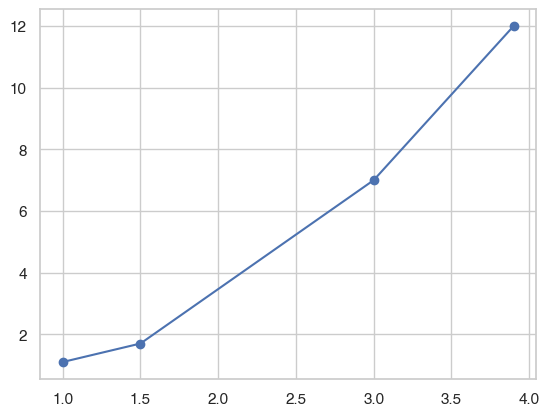

In [21]:
points = [(1, 1.1), (1.5, 1.7), (3, 7), (3.9, 12)]
xx = np.array([p[0] for p in points])
yy = np.array([p[1] for p in points])
plt.plot(xx, yy, "-o")
plt.show()

In [22]:
def rmse(scale, offset):
    yyp = scale * np.exp(xx - offset)
    return np.sum(yy - yyp)**2

def vrmse(params):
    scale, offset = params
    return rmse(scale, offset)

fit1 = opt.minimize(vrmse, x0 = (1,1), 
                   method = "Nelder-Mead")

scale1, offset1 = fit1.x
print("a = %.3f, b = %.3f" % (scale1, offset1))

a = 0.870, b = 1.119


Now, we do the same for the _likelihood_ function. (I am actually cheating a little; I have actually _log_-transformed the exponential function to get a linear function, so I can used RMSE like I would for a linear function).

In [23]:
def likelihood(scale, offset):
    "Likelihood (actually, just MSE for log-transformed data)"
    lyy = np.log(yy)
    lyyp = scale*(xx - offset)
    return np.sum(lyy - lyyp)**2

def vlikelihood(params):
    "Vector version of likelihood"
    scale, offset = params
    return likelihood(scale, offset)

fit2 = opt.minimize(vlikelihood, x0 = (1,1), 
                    method = "Nelder-Mead")

scale2, offset2 = fit2.x
print("a = %.3f, b = %.3f" % (scale2, offset2))

a = 0.979, b = 1.058


And here you can see the difference:

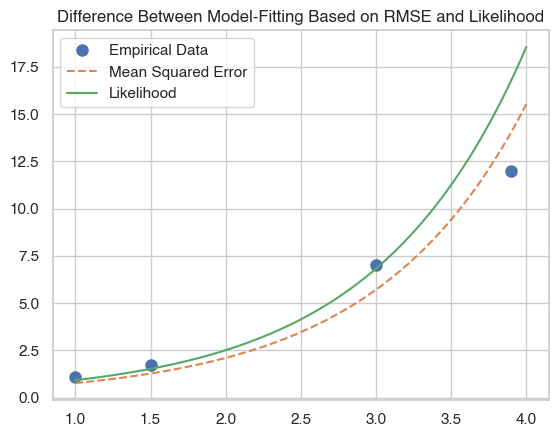

In [24]:
x = np.linspace(1, 4, 100)

y_rmse = scale1 * np.exp(x - offset1)
y_mle = scale2 * np.exp(x - offset2)

plt.plot(xx, yy, "o", label="Empirical Data", markersize=8)
plt.plot(x, y_rmse, "--", label="Mean Squared Error")
plt.plot(x, y_mle, "-", label="Likelihood")
plt.legend()
plt.title("Difference Between Model-Fitting Based on RMSE and Likelihood") 
plt.savefig("difference.png")

# Using Likelihood to Fit Models

In this notebook, we will create and evaluate models for a simple example task, a decision-making paradigm know as the _Incentive Processing Task_ (IPT). It belongs to the class of paradigms known as two-alternative forced choice task (2AFC), which are commonly used for computational modeling. In 2013, this particular paradigm was included in the Young Adult version of the Human Connectome Project; since then, the HCP consortium has collected and made available data from over 1,200 individuals who have performed this task (and many others) while laying in a fMRI scanner.

In the IPT, participants were asked to guess if the number on a mystery card (represented by a "?", and ranging from 1 to 9) was more or less than 5. After making a guess, participants were given feedback, which could take one of three forms, "Win" (a green up arrow and 1USD), "Loss" (a red down arrow and -$0.50), or "Neutral" (a gray double-headed arrow and the number 5). The feedback did not depend on the subject’s response, but was determined in advance; the sequence of pre-defined feedback was identical for all participants. The task was presented in two runs, each of which contains 32 trials divided into four blocks. 

All participants received money as compensation for completing the task, and the amount of reward is standard across subjects. 

## Load Example Data

The data from over 200 individuals is contained the `gambling_clean_data.csv` file.

In [25]:
alldata = pd.read_csv("gambling_clean_data.csv")
alldata

,Unnamed: 0,HCPID,Trial,RunNumber,TrialType,RunTrialNumber,Block,CurrentResponse,QuestionMark.ACC,RT,...,ConsecSameResp,ConsecLargerGuesses,ConsecSmallerGuesses,ConsecRTLess200,FutureResponse,PastResponse,ResponseSwitch,PreviousFeedback,BlockType,BlockTypeCoded
0,1,100307_fnca,1,1,Reward,2,5,2.0,0,380,...,1,0,1,0,3.0,NaN,1.0,NaN,MostlyReward,MostlyReward
1,2,100307_fnca,2,1,Reward,3,5,3.0,0,336,...,1,1,0,0,3.0,2.0,0.0,Reward,MostlyReward,MostlyReward
2,3,100307_fnca,3,1,Punishment,4,5,3.0,0,260,...,2,2,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
3,4,100307_fnca,4,1,Reward,5,5,3.0,0,231,...,3,3,0,0,2.0,3.0,1.0,Punishment,MostlyReward,MostlyReward
4,5,100307_fnca,5,1,Reward,6,5,2.0,0,292,...,1,0,1,0,3.0,3.0,1.0,Reward,MostlyReward,MostlyReward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12667,12668,994273_fnca,31,2,Reward,29,5,3.0,0,321,...,1,1,0,0,3.0,2.0,0.0,Punishment,MostlyReward,MostlyReward
12668,12669,994273_fnca,32,2,Punishment,30,5,3.0,0,614,...,2,2,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
12669,12670,994273_fnca,33,2,Reward,31,5,3.0,0,669,...,3,3,0,0,2.0,3.0,1.0,Punishment,MostlyReward,MostlyReward
12670,12671,994273_fnca,34,2,Reward,32,5,2.0,0,1080,...,1,0,1,0,2.0,3.0,0.0,Reward,MostlyReward,MostlyReward


For these examples, we are going to consider data from two participants.

In [26]:
sub1 = alldata[alldata.HCPID == "100307_fnca"]
sub2 = alldata[alldata.HCPID == "159340_fnca"]

#sub1 = alldata[alldata.HCPID == "154936_fnca"]
#sub2 = alldata[alldata.HCPID == "123117_fnca"]
#sub3 = alldata[alldata.HCPID == "163836_fnca"] # Good!
#sub3 = alldata[alldata.HCPID == "178950_fnca"] #Medium
#sub3 = alldata[alldata.HCPID == "163129_fnca"] #Medium

In [27]:
sub1["More"] = [1 if x == 2.0 else np.NaN for x  in sub1["CurrentResponse"]]
sub1["Less"] = [1 if x == 3.0 else np.NaN for x  in sub1["CurrentResponse"]]
sub1["Index"] = range(1, 65, 1)
sub1["Participant"] = ["Participant 1"]*64

sub2["More"] = [1 if x == 2.0 else np.NaN for x  in sub2["CurrentResponse"]]
sub2["Less"] = [1 if x == 3.0 else np.NaN for x  in sub2["CurrentResponse"]]
sub2["Index"] = range(1, 65, 1)
sub2["Participant"] = ["Participant 2"]*64

msub1 = sub1.melt(id_vars=['Index', 'Participant', 'TrialType'], value_vars=['More', 'Less'])
msub2 = sub2.melt(id_vars=['Index', 'Participant', 'TrialType'], value_vars=['More', 'Less'])
mboth = msub1.merge(msub2, 'outer')
mboth

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/335692026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub1["More"] = [1 if x == 2.0 else np.NaN for x  in sub1["CurrentResponse"]]
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/335692026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub1["Less"] = [1 if x == 3.0 else np.NaN for x  in sub1["CurrentResponse"]]
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/335692026.py:3: SettingWithCopyWarning:

,Index,Participant,TrialType,variable,value
0,1,Participant 1,Reward,More,1.0
1,2,Participant 1,Reward,More,NaN
2,3,Participant 1,Punishment,More,NaN
3,4,Participant 1,Reward,More,NaN
4,5,Participant 1,Reward,More,1.0
...,...,...,...,...,...
251,60,Participant 2,Reward,Less,NaN
252,61,Participant 2,Punishment,Less,NaN
253,62,Participant 2,Reward,Less,NaN
254,63,Participant 2,Reward,Less,NaN


Now we plot the raw series of decisions made by every participant.

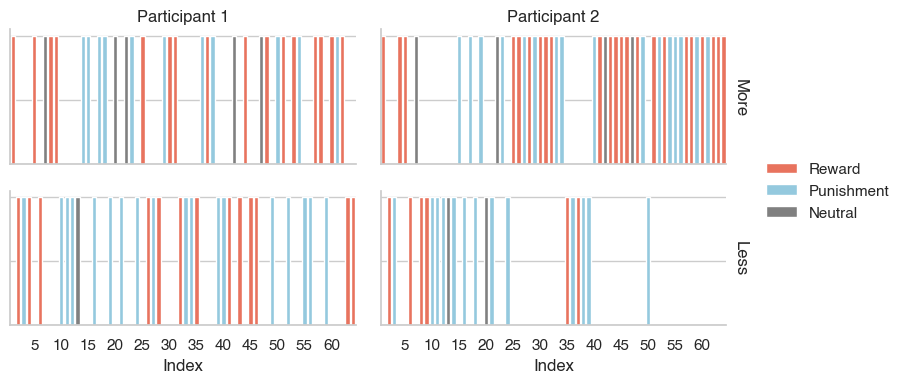

In [28]:
g=sns.catplot(mboth, x="Index", y="value", kind="bar", 
            row="variable", col="Participant", hue="TrialType", palette=["tomato", "skyblue", "grey", "beige"],
              height=2, aspect=2.1,
           margin_titles=True, dodge=False)
g.set(yticklabels=[], ylabel="", xticklabels=[str(x) if x % 5 == 0 else "" for x in range(1, 65)])
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.legend.set_title("")
plt.savefig("rawdecisions.png")
plt.show()

## Analysis Routines

We are going to need a few functions to compute summary statistics for the two participants. These aggregated measures will be needed when fitting models. First, we need to define two global variables: the `FEEDBACK_SCHEDULE` that holds the (constant) sequence of predefined feedback and a `REWARDS` tables that maps a trial type (Punshment, Reward, or Neutral) to the corresponding monetary reward.

In [29]:
# The predefined schedule
FEEDBACK_SCHEDULE = list(sub1.TrialType)

# Mapping of feedback to reward
REWARDS = {"Punishment" : -0.5, 
           "Reward" : 1.0,
           "Neutral" : 0.0} 

After this, we can define a series of functions that measure a participant's or a model's performance during a run of the task. Because the feedback is constant and predefined, no accuracy or learning measures are possible. Instead, we will focus on the _stay probability_, that is, the tendency to repeat the same choice vs. switching. Stay probabilities can be calculated globally (through the entire run) or aggregated by feedback type.  

In [30]:
def response_switch_vector(responses):
    """Creates a vector of response switches for each category"""
    S = np.array(responses[0:-1]) != np.array(responses[1:])
    return S.astype(int)

def pstay(responses):
    """Stay probability"""
    return 1 - np.mean(response_switch_vector(responses))
    
    
def pstay_by_feedback(responses):
    """Stay probabilities following different feedback"""
    df = pd.DataFrame({"switches" : response_switch_vector(responses),
                      "feedback" : FEEDBACK_SCHEDULE[:-1]})
    grouped = df.groupby('feedback').agg('mean')
    S = np.array(list(grouped.switches))
    return 1 - S
    
def persistance(responses):
    """Calculates the persistance index"""
    prstnc = 0
    max_prstnc = 0
    previous = 0
    trial = 1
    for response in responses:
        if response == previous:
            prstnc += 1
            if prstnc > max_prstnc:
                max_prstnc = prstnc
        else:
            prstnc = 1

        previous = response
        trial += 1
    return max_prstnc

Here are some examples

In [31]:
persistance(sub1.CurrentResponse)
#max(sub1.ConsecSameResp)
1-np.mean(response_switch_vector(sub1.CurrentResponse))
byfeedback = pstay_by_feedback(sub1.CurrentResponse)
print(byfeedback)
pstay_by_feedback(sub1.CurrentResponse)

[0.5        0.55172414 0.39285714]


array([0.5       , 0.55172414, 0.39285714])

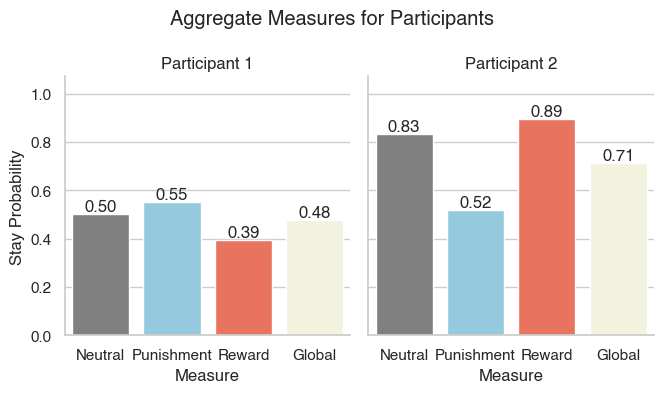

In [32]:
aggregate1 = list(pstay_by_feedback(sub1.CurrentResponse)) + [pstay(sub1.CurrentResponse)]
df1 = pd.DataFrame({"Participant" : ["Participant 1"]*4,
                    "Stay Probability" : aggregate1,
                    "Measure" : ["Neutral",  "Punishment", "Reward", "Global"]})

aggregate2 = list(pstay_by_feedback(sub2.CurrentResponse)) + [pstay(sub2.CurrentResponse)]
df2 = pd.DataFrame({"Participant" : ["Participant 2"]*4,
                    "Stay Probability" : aggregate2,
                    "Measure" : ["Neutral",  "Punishment", "Reward", "Global"]})

both = df1.merge(df2, 'outer')

g=sns.catplot(
    height=4,
    aspect=0.85,
    data=both, 
    x="Measure", 
    y="Stay Probability", 
    col="Participant", 
    palette=["grey", "skyblue", "tomato", "beige"],
    kind="bar",
    facet_kws=dict(margin_titles=True)
)


g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Aggregate Measures for Participants')
g.set_titles(template="{col_name}")
# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

plt.tight_layout()
plt.savefig("aggregate_measures.png")
plt.show()

## Declarative Model

In ACT-R, memories are encoded as _chunks_. Chunks have an associated scalar quantity, called _activation_. A chunk’s activation reflects the history of encoding and retrieval of that information. This history is condensed the sum of power decaying traces of previous encounters with that knowledge. Specifically, the activation $A_t(c)$ of chunk $c$ at time $t$ is given by:

$$A_t(c) = \log \sum_i (t – t_i)^{–d}$$

### PyACTUP Declarative Model

We are going to implement our declarative memory model in PyACT-Up, which is a Python implementation of ACT-R's declarative module. Since we only need the memory part, there is no need to have the full architecture.


In [33]:
OTHER = {2.0 : 3.0, 3.0: 2.0} # The Other response

def simulate(n=100, decay = 0.5, noise = 0.25, iti=2.5):
    results = []
    run = []
    
    for i in range(n):
        # Set up
        model = pau.Memory(decay = decay, noise=noise)
        model.learn({"response" : 2.0, "outcome" : "Reward"})
        model.learn({"response" : 3.0, "outcome" : "Reward"})
        
        # Run the task
        model.advance(iti)
        
        for feedback in FEEDBACK_SCHEDULE:
            memory = model.retrieve()
            outcome = memory["outcome"]
            
            response = memory["response"]
            if outcome == "Punishment":
                response = OTHER[response]
                    
            run.append(response)
            model.learn({"response" : response, "outcome" : feedback}, advance=iti)
        
        results.append(run)
        run = []
    
    return results

### Forward Simulations

With the model in place, we can run an empirical (Monte Carlo) simulation of the model's predictions for two specific parameter values, e.g. $d=0.5$ and $s=0.25$.

In [34]:
results = simulate(5000, decay=0.5, noise=0.25)
res = [pstay(x) for x in results]

We need to use a Kernel Desnity Estimator to get a continuous probability density from the discrete data.

In [35]:
kde = sm.nonparametric.KDEUnivariate(res).fit()
xx = np.linspace(0, 1, 101)
yy = kde.evaluate(xx)

Now, we visualize both the distribution of our results, its KDE probability density, and where the two participants lay on this curve.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


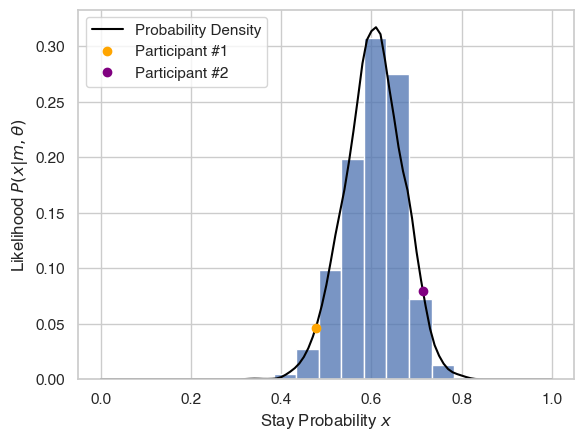

In [36]:
x1 = pstay(sub1.CurrentResponse)
x2 = pstay(sub2.CurrentResponse)

XX = [x1, x2]
y1, y2 = kde.evaluate(XX) * 0.05

ax = sns.histplot(res, binwidth=0.05, stat='probability')
ax.set_xlabel("Stay Probability $x$")
ax.set_ylabel(r"Likelihood $P(x | m, \theta)$")
ax.plot(xx, yy*0.05, label="Probability Density", color="black")
ax.plot(x1, y1, 'o', label="Participant #1", color="orange")
ax.plot(x2, y2, 'o', label="Participant #2", color="purple")
ax.legend()
plt.savefig("kde.png")
plt.show()

## Empirical Fitting to Participant 1 

The previous suggests that the model, with its default parameters _d_ = 0.5 and _s_ = 0.25, does a poor job at fitting the behavior Participant 1. Is there a set of parameters that maximizes the probability of reproducing their data? 

A simple way to do is to run the model under different combinations of parameters. For example, we could parametrically vary the values of d and n in fixed intervals, and record the log-likelihood values for the data of participant 1.  Figure 5 depicts the values of the likelihood function P(x| m, theta) for different combinations of _d_ and _s_ in the case of Participant 1.  

In [37]:
dspace = np.linspace(0.2, 0.9, 8)
nspace = np.linspace(0.2, 0.9, 8)
matrix = np.zeros((len(dspace), len(nspace)))

for i, d in enumerate(tqdm(dspace)):
    for j, n in enumerate(nspace):
        results = simulate(7500, decay = d, noise = n)
        res=[pstay(x) for x in results]
        kde = sm.nonparametric.KDEUnivariate(res).fit()
        LL = np.log(kde.evaluate(x1) * 0.05)
        matrix[i,j] = LL
            

  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/1342321529.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = LL


###  Visualize the parameter space

Here is a 2D representation of the distribution of likelihoods across the different values of _d_ and _s_.

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/1723462150.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in nspace])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/1723462150.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in dspace])


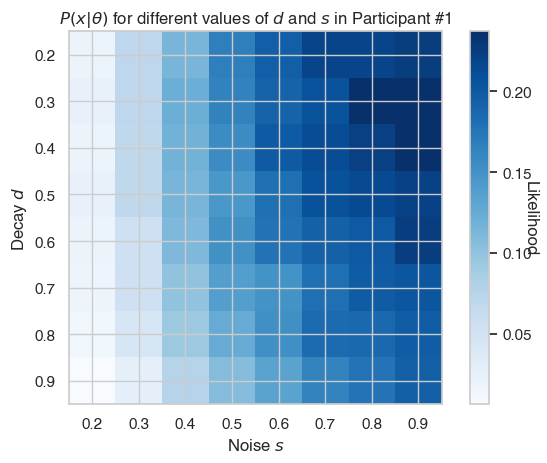

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(np.exp(matrix), cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Likelihood", rotation=270, )
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in nspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in dspace])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$P(x | \theta)$ for different values of $d$ and $s$ in Participant #1")
plt.tight_layout()
plt.savefig("paramspace_empirical.png")
plt.show()

## Fitting a Model Using Optimization Functions

Running simulations in grid search is typically prohibitive. For this reasons, it is typically more convenient to use optimization techniques. Because we do not have an analytic expressions for how the parameters translate into P(Stay) values, we must use a derivative-free method, such as Powell’s method or the Nelder-Mead simplex method. These methods explore the parameter space efficiently and typically require significantly less computations.

To do so, we need to create a vector function that can be passed to `scipy.optimize.minimize`.

In [39]:
def empiricalLL(x, decay, noise, n=7500):
    results = simulate(n, decay = d, noise = n)
    res=[pstay(run) for run in results]
    kde = sm.nonparametric.KDEUnivariate(res).fit()
    LL = np.log(kde.evaluate(x) * 0.05)
    return LL

X = x1
intermediates = []

def vLL(array):
    """Vector function of procedural log-likelihood"""
    global X
    global intermediates
    decay, noise = array
    params = [decay, noise]
    pval = np.exp(empiricalLL(X, decay, noise))
    print([params, pval])
    intermediates.append(params)
    return -1 * pval

And now, we do run the optimization procedure.

In [40]:
intermediates = []
X0 = [np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.5)]
fit = opt.minimize(vLL, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.2, 0.9], [0.2, 0.9]], 
                   options={"xtol":0.025, "ftol" : 0.025, "maxiter" : 5})

[[0.5964718349942314, 0.3703278478831269], array([0.27110391])]
[[0.46737620787507356, 0.3703278478831269], array([0.26802175])]
[[0.6326237921249264, 0.3703278478831269], array([0.25669486])]
[[0.36524758424985276, 0.3703278478831269], array([0.2620211])]
[[0.47801578228926817, 0.3703278478831269], array([0.25970621])]
[[0.42025430048905776, 0.3703278478831269], array([0.26410721])]
[[0.4493772408683402, 0.3703278478831269], array([0.26218969])]
[[0.45904287262694266, 0.3703278478831269], array([0.25917254])]
[[0.46737620787507356, 0.46737620787507356], array([0.25698931])]
[[0.46737620787507356, 0.6326237921249264], array([0.27119545])]
[[0.46737620787507356, 0.7347524157501472], array([0.26363361])]
[[0.46737620787507356, 0.6218262731556432], array([0.26832612])]
[[0.46737620787507356, 0.6713841623977266], array([0.26136385])]
[[0.46737620787507356, 0.6474289361526051], array([0.25187954])]


In [41]:
fit

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.27119545176800064
       x: [ 4.674e-01  6.326e-01]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 14

In [42]:
intermediates.append(fit.x)

For example, the path explored by Powell’s method  in the data is shown in Figure 6 as a series of points of increasingly greater opacity from the first point sampled to the last. The final result is shown as a magenta point

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2886719968.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x,2)) for x in nspace])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2886719968.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in dspace])


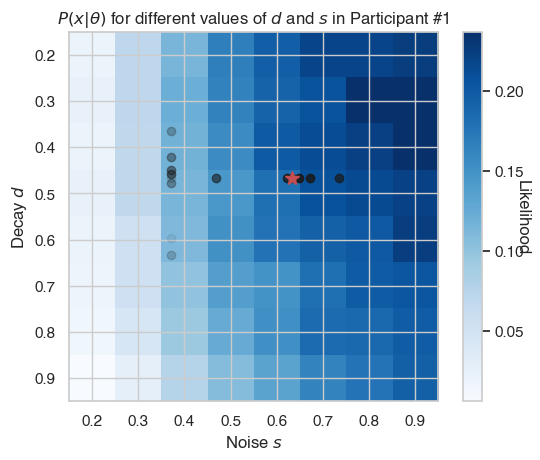

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(np.exp(matrix), interpolation='nearest', cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Likelihood", rotation=270)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in nspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in dspace])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$P(x | \theta)$ for different values of $d$ and $s$ in Participant #1")

previous = None
i = 1
N = len(intermediates)
coords =[[(x[0] - 0.2)/0.7 * 7, (x[1] - 0.2)/0.7 * 7] for x in intermediates]

for y, x in coords[:-1]:
    ax.plot(x, y, 'o', color="k", alpha=i/N)
    if previous is not None:
        xp, yp = previous
    
    previous = [x, y]
    i += 1

y, x = coords[-1]
ax.plot(x, y, '*', color="r", markersize=10)
plt.savefig("powell.png")

## Joint PDF

Cognitive researchers rarely focus on a single aggregate behavioral measure; more often than not, any task yields two or more measures of interest. For example, any experimenters using the Stroop task would be interested in response times for congruent and incongruent trials. 
The principles described above work for any number of variables.

However, remember that the definition of likelihood is based on the _joint_ probability distribution of the data. When running simulations, however, the joint probability distributions can be estimated directly from the data.

In the IPT, for example, we might want to consider the stay probabilities after a "reward" or "punishment" trial.

In [249]:
opt_results = simulate(1000, decay=0.47, noise=0.65)
partial = [pstay_by_feedback(x) for x in opt_results]
pstay_reward = [x[2] for x in partial]
pstay_punishment = [x[1] for x in partial]
df = pd.DataFrame({"reward" : pstay_reward, "punishment" : pstay_punishment})

The likelihoods of the two participants are very different when visualized across both measures.

In [259]:
#ax=sns.kdeplot(df, x="reward", y="punishment", fill=True, cmap="mako", cbar=True, common_norm=True)
fig, axs = plt.subplots(1, 2)

sns.histplot(df, x="reward", y="punishment", binwidth=0.075, cmap="Blues",
                binrange=(0, 0.8), fill=True, cbar=True, stat="probability", ax=axs[0])

axs[0].set_xlabel("Stay Probability after Reward")
axs[0].set_ylabel("Stay Probability after Punishment")
y1, x1 = pstay_by_feedback(sub1.CurrentResponse)[1:]
y2, x2 = pstay_by_feedback(sub2.CurrentResponse)[1:]

axs[0].plot(x1, y1, 'o', label="Participant #1", color='orange')
axs[0].plot(x2, y2, 'o', label="Participant #2", color='purple')
axs[0].legend()
axs[0].set_title("Joint Probability Distributions of Stay Probabilities")
#plt.tight_layout()
#plt.savefig("joint.png")
#plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Joint Probability Distributions of Stay Probabilities')

In [53]:
print([x1, y1, x2, y2])

[0.3928571428571429, 0.5517241379310345, 0.8928571428571429, 0.5172413793103448]


### Optimizing on two measures

In [281]:
def empirical_joint_LL(x, decay, noise, n=2500):
    results = simulate(n, decay = d, noise = n)
    res=np.array([pstay_by_feedback(run)[1:] for run in results])
    kde = sm.nonparametric.KDEMultivariate(res, "cc")
    #kde = stats.gaussian_kde(np.array(res).T)
    LL = np.log(kde.pdf([x1, y1]))
    return LL

X = [x1, y1]
intermediates = []

def v_joint_LL(array):
    """Vector function of procedural log-likelihood"""
    global X
    global intermediates
    decay, noise = array
    params = [decay, noise]
    pval = np.exp(empirical_joint_LL(X, decay, noise))
    print([params, pval])
    intermediates.append(params)
    return -1 * pval

### Optimize

In [284]:
intermediates = []
X0 = [np.random.uniform(0.0, 0.1), np.random.uniform(0.5, 0.9)]
fit = opt.minimize(v_joint_LL, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0, 0.2], [0.2, 0.9]], 
                   options={"xtol":0.025, "ftol" : 0.025, "maxiter" : 5})


[[0.09400938825651493, 0.5454512629018632], 7.897932745090902]
[[0.07639320225002103, 0.5454512629018632], 8.38487404274194]
[[0.12360679774997896, 0.5454512629018632], 8.69689830069858]
[[0.15278640450004205, 0.5454512629018632], 7.6493409952206495]
[[0.10593832640253739, 0.5454512629018632], 7.939623714057113]
[[0.1347524157501472, 0.5454512629018632], 9.007820015392223]
[[0.1430857496877973, 0.5454512629018632], 8.156721781267526]
[[0.1347524157501472, 0.46737620787507356], 9.106300277843182]
[[0.1347524157501472, 0.6326237921249264], 8.75236775617545]
[[0.1347524157501472, 0.36524758424985276], 8.759740779857886]
[[0.1347524157501472, 0.49826967516047416], 9.217753265707934]
[[0.1347524157501472, 0.549588381312416], 8.319459997604913]
[[0.1347524157501472, 0.5178716766518476], 8.212990642326277]
[[0.1347524157501472, 0.48646942068778404], 8.781966810564622]
[[0.1347524157501472, 0.5066030091936236], 7.578844461025278]
[[0.17549544324377947, 0.4510880874190851], 8.943410447505501]
[

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

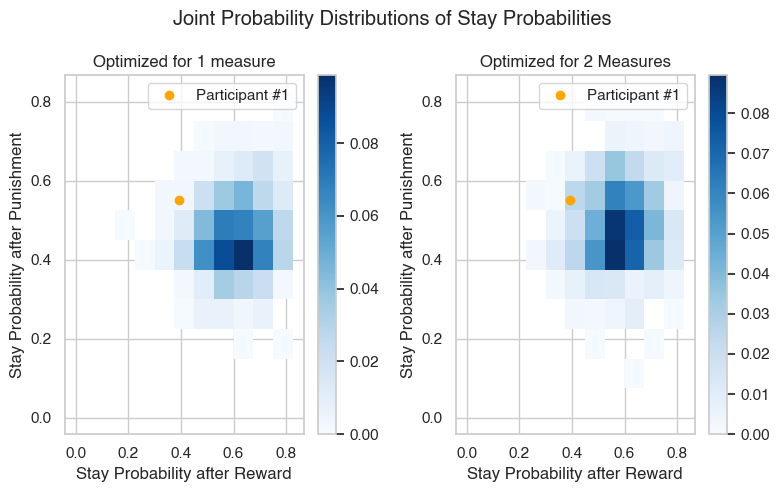

In [295]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

opt_results = simulate(1000, decay=0.47, noise=0.65)
partial = [pstay_by_feedback(x) for x in opt_results]
pstay_reward = [x[2] for x in partial]
pstay_punishment = [x[1] for x in partial]
df = pd.DataFrame({"reward" : pstay_reward, "punishment" : pstay_punishment})

sns.histplot(df, x="reward", y="punishment", binwidth=0.075, cmap="Blues",
                binrange=(0, 0.8), fill=True, cbar=True, stat="probability", ax=axs[0])

axs[0].set_xlabel("Stay Probability after Reward")
axs[0].set_ylabel("Stay Probability after Punishment")
y1, x1 = pstay_by_feedback(sub1.CurrentResponse)[1:]
y2, x2 = pstay_by_feedback(sub2.CurrentResponse)[1:]

axs[0].plot(x1, y1, 'o', label="Participant #1", color='orange')
#axs[0].plot(x2, y2, 'o', label="Participant #2", color='purple')
axs[0].legend()
axs[0].set_title("Optimized for 1 measure")

opt_results = simulate(1000, decay=0.12, noise=0.57)
partial = [pstay_by_feedback(x) for x in opt_results]
pstay_reward = [x[2] for x in partial]
pstay_punishment = [x[1] for x in partial]
df = pd.DataFrame({"reward" : pstay_reward, "punishment" : pstay_punishment})
sns.histplot(df, x="reward", y="punishment", binwidth=0.075, cmap="Blues",
                binrange=(0, 0.8), fill=True, cbar=True, stat="probability", ax=axs[1])

axs[1].set_xlabel("Stay Probability after Reward")
axs[1].set_ylabel("Stay Probability after Punishment")

axs[1].plot(x1, y1, 'o', label="Participant #1", color='orange')
#axs[1].plot(x2, y2, 'o', label="Participant #2", color='purple')
axs[1].legend()
axs[1].set_title("Optimized for 2 Measures")
plt.suptitle("Joint Probability Distributions of Stay Probabilities")
plt.tight_layout()
plt.savefig("joint.png")
plt.show()

# Trial By Trial

So far, we have considered the case of aggregate measures of behavior. Aggregate measures, however, suffer from considerable pitfalls. Among the other things, they are sensitive to extreme values. 

It is possible to remove outlier observations. However, MLE estimation handles them nicely.  In fact, trial-by-trial estimation is often used and recommended in other modeling paradigms (A…) and is the basis of common frameworks such as accumulator models.

There are some disadvantages, For example, in trial-by-trial analysis, one can typically observe only the specific response time and choice made in that particular instance. Experimental studies often focus on derived measures, such as the differences between different groups of trials (congruent vs, incongruent response times in the Stroop task). For example, the mean probability of switching after a reward or punishment, which was used in the previous example, is not a measure that exists when looking at the data at the granularity level of trial-by-trial analysis. 

Trial-by-trail fitting is also a nice way to deal with _outliers_. Consider this data from point from Hake et al. (2023).

In [54]:
history = pd.read_csv("outlier_history.csv")
mean_with = np.mean(history.reactionTime)
mean_without = np.mean([x for x in history.reactionTime if x < 100])
plt.plot(history.reactionTime, "-o", label="Empirical Data")
plt.axhline(mean_with, linestyle="--", label="Mean With Outlier (%.1f s)" % (mean_with), color="purple")
plt.axhline(mean_without, linestyle="--", label="Mean Without Outlier (%.1f s)" % (mean_without), color="orange")
plt.legend()
plt.xlabel("Trial")
plt.ylabel("Response Time (s)")
plt.title("Example of Outlier Data")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'outlier_history.csv'

## Formal Definition

In trial-by-trial data analysis, the vector of data **x** is a vector of points that were acquired at consecutive times $t = 1, 2, \dots , N$. 

$$L(m, \theta | x) = P(x | m, \theta); x = \{x_{t = 1}, x_{t = 2}, … x_{t = N}\}$$

In this case, the joint probability distribution of the data is best understood as a conditional distribution of observing the data point xt at times t, given that we have observed all of the previous data points at times $t – 1, t – 2, \dots , 0$. Following this logic, our probability of observing the full series of data x can be expanded as the probabilities of observing each data point, conditional on all of the preceding ones:   

$$P(x | m, \theta) = P(x1 | m, \theta) \times P(x_2 | m, \theta, x_1) \times \dots \times P(xN | m, \theta, x_1, x_2, … xN-1 )$$

This leads to an intricate series of conditional probabilities. Fortunately, ACT-R is a single-step Markov model, and its future behavior is determined solely by its current state (as embedded in the current state of its knowledge, buffers, and parameters) and not by its previous history of choices. The previous history of interaction with the environment can have an effect on the model only to the extent by which it is captured by the model’s knowledge or parameters. For example, a model could make decisions based on memories of previous actions, or be more likely to retrieve certain memories after having previously seen them, or more likely to select an action after experiencing a reward. So, if we model’s knowledge is correctly updated after every choice, the temporal dependencies between choices can be ignored, and the Equation above becomes:

$$ L(m, \theta | x) = P(x | m, \theta) =  P(x_1 | m, \theta) \times P(x_2 | m, \theta) \times \dots \times P(x_N | m, \theta) = 
\prod_i P(x_i | m, \theta) $$

And the global log-likelihood becomes the sum of each trial’s log-likelihood:

$$\log L(m, \theta | x)	= \log \prod_i i P(x_i | m, \theta) = \sum_i \log P(x_i | m, \theta)$$

## Declarative Model Example

To run trial-by-trial analysis, we need to re-implement ACT-R's equations. 

It is highly impractical to collect trial-by-trial probability densities using Monte Carlo simulations. So, it is de facto necessary to use analytic definitions that specify the probabilities that a specific procedural action or memory chunk are selected—and the probability densities of their associated response times. Fortunately, they are not too difficult to calculate.

In the case of a procedural system, the probability of selecting a production p is a softmax function of its utility:

$$P(p) = e^{–U(p)/s} / \sum_i e^{–U(i) / s}$$

where τ is a parameter that controls the noise associated with the selection (:EGS in Table 1).
Similarly, In the case of the declarative system, the probability P(c) of retrieving a specific chunk c is a softmax function of its activation:

$$P(c) = e^{-A(c) / s} / \sum_i e^{–A(i) / s}$$

where s in a parameter that controls selection noise in declarative memory (:ANS in Table 1). 
The probability distribution function for accuracy is defined over a discrete space–accuracies are either 1 or 0. The probability of a correct or incorrect answer is given by $P(c)$ and $1 – P(c)$ respectively.

The response time associated with retrieving a chunk is a deterministic function of that chunk’s activation. Specifically:

$$RT = t_0 + Fe^{–A(c)}$$

Where t0 is a term that absorbs perception/motor times. The source of variability in RTs is given by the noise s. Because s is distributed as a logistic function, the activation A(c) + s is also distributed as a logistic distribution with mean μ = A(c) and σ = πs/√3. Therefore, t0 + Fe–A(m) + s is a shifted log-logistic distribution with parameters $\alpha = e^μ = e^{–A(c)}$, $\beta = 1/\sigma  = \sqrt{3}/\pi s$, and $\gamma = t_0$

$$ P(t) = [ \beta / (F \alpha )] [(t - t_0) / \alpha]^{\beta-1} / (1 + (t - t_0) / (F \alpha)^{\beta})^2$$

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/291639352.py:5: RuntimeWarning: invalid value encountered in power
  p =  ((beta/alpha) * (t/alpha)**(beta -1)) / (1 + (t/alpha)**beta)**2


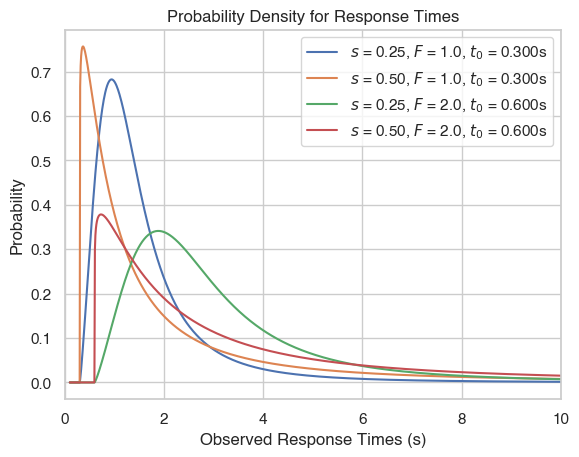

In [55]:
def rt_prob(observed, activation, noise, f, ter):
    alpha = np.exp(-activation) * f
    beta = np.sqrt(3)/(np.pi*noise)
    t = observed - ter
    p =  ((beta/alpha) * (t/alpha)**(beta -1)) / (1 + (t/alpha)**beta)**2
    p_fixed = np.nan_to_num(p, nan=0)
    return p_fixed

t = np.linspace(0.1, 10, 1000)

params1 = (0.25, 1, 0.3)
params2 = (0.5, 1, 0.3)
params3 = (0.25, 2, 0.6)
params4 = (0.5, 2, 0.6)

prt1 = rt_prob(t, 0, *params1)
prt2 = rt_prob(t, 0, *params2)
prt3 = rt_prob(t, 0, *params3)
prt4 = rt_prob(t, 0, *params4)

plt.plot(t, prt1, label="$s$ = %.2f, $F$ = %.1f, $t_0$ = %.3fs" % params1)
plt.plot(t, prt2, label="$s$ = %.2f, $F$ = %.1f, $t_0$ = %.3fs" % params2)
plt.plot(t, prt3, label="$s$ = %.2f, $F$ = %.1f, $t_0$ = %.3fs" % params3)
plt.plot(t, prt4, label="$s$ = %.2f, $F$ = %.1f, $t_0$ = %.3fs" % params4)

plt.title("Probability Density for Response Times")
plt.xlabel("Observed Response Times (s)")
plt.ylabel("Probability")
plt.xlim((0, 10))
plt.legend()
plt.show()

To implement the trial-by-trial method, we need to reimplement ACT-R's equations from scratch

In [56]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

And now, we can compute the trial-by-trial log likelihood as follows:

In [57]:
def trialbytrialLL(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = [2.0, 3.0]
    
    outcomes = [REWARDS[x] for x in REWARDS.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.001] for x in memories]))
    
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        probs = boltzmann(options, values, temp)
        
        if not np.isnan(response):
            # The probability of picking option X is the probability of retrieving a success for X 
            # plus the probability of retrieving a punishment for Y.
            prob1 = probs["%s-%s" % (response, 1.0)]
            other = [x for x in choices if x != response]
            prob2 = probs["%s-%s" % (other[0], -0.5)]
        
        
            # Sum up the LLs
            LL += np.log(max(prob1 + prob2, 10e-10))
        
            # If we have a non-neutral feedback, add a trace
            if REWARDS[feedback] != 0:
                DM["%s-%s" % (response, REWARDS[feedback])] += [time]
        
        if trial % 8 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 32 == 0:
            time += (1 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return LL

For example, this is the log-likelihood of predicting the sequence of choices made by participant #1  with parameters $d=0.5$ and $s=0.25$ 

In [58]:
ll = trialbytrialLL(sub1, 0.5, 0.25)
print(ll)
print(np.exp(ll))

-98.97149622992075
1.0404598395265818e-43


## Empirical Fitting

Because the trial-by-trial model is deterministic, there is not need to run hundreds or thousands of trials to estimate likelihood; model above returns the likelihood value in a single pass.

This means, among other things, that we can collect a much higher resolution density of values.

In [59]:
dspace = np.linspace(0.2, 0.9, 63)
nspace = np.linspace(0.2, 0.9, 63)
matrix = np.zeros((len(dspace), len(nspace)))

for i, d in enumerate(tqdm(dspace)):
    for j, n in enumerate(nspace):
        matrix[i,j] = trialbytrialLL(sub1, d, n)

  0%|          | 0/63 [00:00<?, ?it/s]

Below is a plot of the grid search. Notice that the surface is much smoother now. Also, notice that the color scale is now in _log_-likelihoods: the probability values would be too small (on the order of $1e^{-19}$)

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/865202064.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/865202064.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


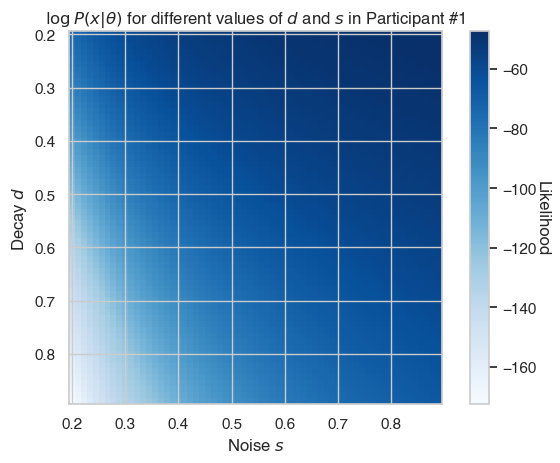

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(matrix, interpolation='nearest', cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Likelihood", rotation=270, labelpad=10)

ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$\log P(x | \theta)$ for different values of $d$ and $s$ in Participant #1")
plt.tight_layout()
plt.savefig("paramspace_tbt.png")
plt.show()

## Model Optimization

As before, we can use derivative-free optimization techniques to fit this model as well. We start by redefining our vector function:

In [61]:
intermediates = []
def vtrialbytrialLL(array):
    """Vector function of data"""
    global sub1
    decay, temp = array
    intermediates.append([decay, temp])
    return -1 * trialbytrialLL(sub1, decay, temp)

And then, we run Powell's method

In [62]:
intermediates = []
X0 = [np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.5)]
fit = opt.minimize(vtrialbytrialLL, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.2, 0.9], [0.2, 0.9]], 
                   options={"xtol":0.25, "ftol" : 0.25, "maxiter" : 5})

for i, params in enumerate(intermediates):
    d, n = params
    print("Iteration %d, d = %.6f, s = %.6f" % (i+1, d, n))

Iteration 1, d = 0.730540, s = 0.272511
Iteration 2, d = 0.467376, s = 0.272511
Iteration 3, d = 0.632624, s = 0.272511
Iteration 4, d = 0.365248, s = 0.272511
Iteration 5, d = 0.365248, s = 0.467376
Iteration 6, d = 0.365248, s = 0.632624
Iteration 7, d = 0.365248, s = 0.734752
Iteration 8, d = 0.234659, s = 0.900000
Iteration 9, d = 0.576545, s = 0.467376
Iteration 10, d = 0.445956, s = 0.632624
Iteration 11, d = 0.365248, s = 0.734752
Iteration 12, d = 0.334807, s = 0.773273
Iteration 13, d = 0.296553, s = 0.821678
Iteration 14, d = 0.266112, s = 0.860198
Iteration 15, d = 0.266112, s = 0.467376
Iteration 16, d = 0.266112, s = 0.632624
Iteration 17, d = 0.266112, s = 0.734752
Iteration 18, d = 0.502038, s = 0.436212
Iteration 19, d = 0.386670, s = 0.582199
Iteration 20, d = 0.315368, s = 0.672424
Iteration 21, d = 0.247369, s = 0.758470
Iteration 22, d = 0.273342, s = 0.725604
Iteration 23, d = 0.229276, s = 0.781366
Iteration 24, d = 0.218093, s = 0.795516
Iteration 25, d = 0.20983

25


/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2333955849.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2333955849.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


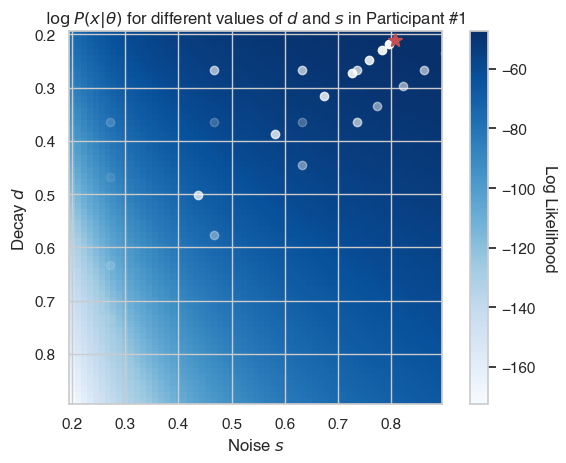

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(matrix, interpolation='nearest', cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Log Likelihood", rotation=270, labelpad=15)

ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$\log P(x | \theta)$ for different values of $d$ and $s$ in Participant #1")
plt.tight_layout()
previous = None
i = 1
N = len(intermediates)

coords =[[(x[0] - 0.2)/0.7 * 63, (x[1] - 0.2)/0.7 * 63] for x in intermediates]
print(N)
for y, x in coords[:-1]:
    ax.plot(x, y, 'o', color="w", alpha=i/N)
    if previous is not None:
        xp, yp = previous
    
    previous = [x, y]
    i += 1

y, x = coords[-1]
ax.plot(x, y, '*', color="r", markersize=10)
plt.autoscale(False)
plt.savefig("powell_tbt.png")
plt.show()


We can now look at the difficult-to-fit Participant #2

In [65]:
dspace = np.linspace(0.2, 0.9, 63)
nspace = np.linspace(0.2, 0.9, 63)
matrix2 = np.zeros((len(dspace), len(nspace)))

for i, d in enumerate(tqdm(dspace)):
    for j, n in enumerate(nspace):
        matrix2[i,j] = trialbytrialLL(sub2, d, n)

  0%|          | 0/63 [00:00<?, ?it/s]

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/1761054202.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/1761054202.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


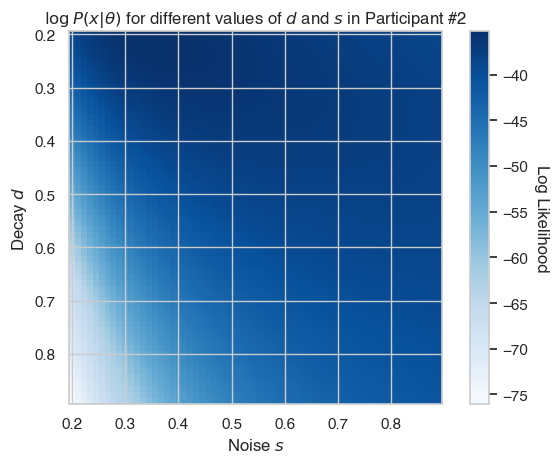

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(matrix2, interpolation='nearest', cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Log Likelihood", rotation=270, labelpad=15)

ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$\log P(x | \theta)$ for different values of $d$ and $s$ in Participant #2")
plt.tight_layout()
plt.savefig("paramspace_tbt_sub2.png")
plt.show()

In [69]:
intermediates2 = []
def vtrialbytrialLL2(array):
    """Vector function of data"""
    global sub2
    decay, temp = array
    intermediates2.append([decay, temp])
    return -1 * trialbytrialLL(sub2, decay, temp)

intermediates2 = []
X0 = [np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.5)]
fit = opt.minimize(vtrialbytrialLL2, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.2, 0.9], [0.2, 0.9]], 
                   options={"xtol":0.1, "ftol" : 0.1, "maxiter" : 5})

for i, params in enumerate(intermediates2):
    d, n = params
    print("Iteration %d, d = %.6f, s = %.6f" % (i+1, d, n))

Iteration 1, d = 0.568027, s = 0.295185
Iteration 2, d = 0.467376, s = 0.295185
Iteration 3, d = 0.632624, s = 0.295185
Iteration 4, d = 0.365248, s = 0.295185
Iteration 5, d = 0.302129, s = 0.295185
Iteration 6, d = 0.263119, s = 0.295185
Iteration 7, d = 0.263119, s = 0.467376
Iteration 8, d = 0.263119, s = 0.632624
Iteration 9, d = 0.263119, s = 0.365248
Iteration 10, d = 0.263119, s = 0.398581
Iteration 11, d = 0.263119, s = 0.431914
Iteration 12, d = 0.200000, s = 0.419985
Iteration 13, d = 0.600932, s = 0.284027
Iteration 14, d = 0.447790, s = 0.335958
Iteration 15, d = 0.353142, s = 0.368053
Iteration 16, d = 0.294647, s = 0.387890
Iteration 17, d = 0.258495, s = 0.400149
Iteration 18, d = 0.221612, s = 0.412656
Iteration 19, d = 0.231776, s = 0.409210
Iteration 20, d = 0.211448, s = 0.416103
Iteration 21, d = 0.221612, s = 0.467376
Iteration 22, d = 0.221612, s = 0.632624
Iteration 23, d = 0.221612, s = 0.365248
Iteration 24, d = 0.221612, s = 0.331914
Iteration 25, d = 0.22161

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2370167070.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2370167070.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


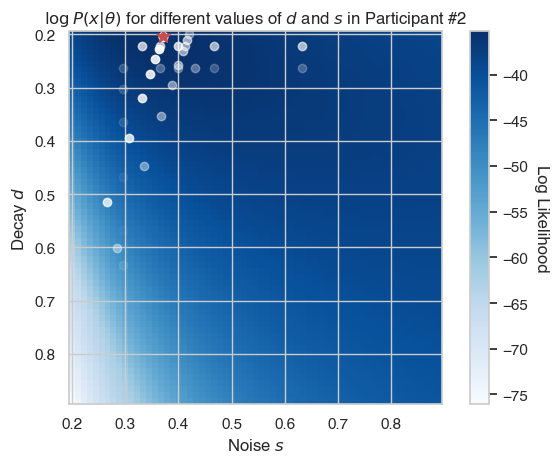

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(matrix2, interpolation='nearest', cmap="Blues")
cbar = fig.colorbar(cax)
cbar.set_label("Log Likelihood", rotation=270, labelpad=15)


ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel("Decay $d$")
ax.set_xlabel("Noise $s$")
ax.set_title(r"$\log P(x | \theta)$ for different values of $d$ and $s$ in Participant #2")
plt.tight_layout()
previous = None
i = 1
N = len(intermediates2)

coords =[[(x[0] - 0.2)/0.7 * 63, (x[1] - 0.2)/0.7 * 63] for x in intermediates2]

for y, x in coords[:-1]:
    ax.plot(x, y, 'o', color="w", alpha=i/N)
    if previous is not None:
        xp, yp = previous
    
    previous = [x, y]
    i += 1

y, x = coords[-1]
ax.plot(x, y, '*', color="r", markersize=10)
plt.autoscale(False)
plt.savefig("powell_tbt_sub2.png")
plt.show()


The highest log-likelihood is obtained for d = 0.263119, s = 0.431914, where it is:

In [33]:
trialbytrialLL(sub2, 0.263119, 0.431914)

-35.64765788986554

# Model Selection

The possibility of calculating likelihoods for a model sets the stage for a more formal approach to model comparison and selection. Suppose we have two models, $m_1$ and $m_2$. The probability that $m_1$ explains the data better than $m_2$ can be estimated using Bayes theorem:

$$P(m_1 | x) = P(x | m_1) P(m_1) / P(x)  =  P(x | m_1) P(m_1) / [P(x | m_1) P(m_1) + P(x | m_2) P(m_2)]$$

If both models are equiprobable, then $P(m_1) = P(m_2)$ and:

$$P(m_1 | x) = P(x | m_1)  / [P(x | m_1) + P(x | m_2) ] $$

And therefore:

$$P(m_1 | x) = L(m_1) / [ L(m_1) + L(m_2)]$$

Another common way to compare models is through Bayes Factors, or BF, that is, the ratio between the two models' posterior probabilities. BFs can also be expressed in terms of likelihoods and log-likelihoods.

$$ BF_{1,2} = P(m_1 | x) / P(m_2 | x) = P(x | m_1) / P(x | m_1) = L (m_1) / L (m_2)$$

And, in terms of log-likelihood:

$$\log BF_{1,2} = \log [L(m_1) / L(m_2)] = \log L(m_1)  -  \log L(m_2)$$

So, Eq. 7 ensures that the difference in log-likelihoods between two models corresponds to the log of the Bayes Factor of the evidence in favor of the first model over the second.
There is no straightforward relation to transform Bayes Factors into p-values. A simple rule of thumb consists of calculating an equivalent _p_-value assuming that the second model, $m_2$, represents the null hypothesis, and that posterior probability a model, $P(m_1 | x)$ represents its _p_-value $p_1$. Under these conditions, $p_1 +  p_2 = 1$ and  $BF_{1,2} = p_1 / p_2$; therefore, $p_1 = 1  / (BF + 1)$. For example, a $BF = 19$ implies $p = .05$, and a $BF_{1,2} > 19$ implies a "significant" _p_-value at what would be the canonical significance threshold of 0.05.

In general, however, an alternative model is _not_ equivalent to the null hypothesis. For this reason, it is more common to use agreed-upon scales to translate BF values into corresponding amounts of evidence. Perhaps the most common is the one suggested by Kass & Raftery (1995).

In [44]:
def BayesMS(logl1, logl2):
    "Bayesian Model Selection (poster of M1)"
    l1 = np.exp(logl1)
    l2 = np.exp(logl2)
    return l1 / (l1 + l2)

def BayesFactor(logl1, logl2):
    "Bayes Factor"
    return np.exp(logl1 - logl2)

## Is my model better than chance?

To answer this question, we need a chance model. In trial-by-trial analysis, the log-likelihood of a chance model is:
    
$$\log L(chance|x) = T \times \log (1/N)$$

In the case of the IPT, this quantity is $64\times \log(1/2)$

In [45]:
# Log likelihood declarative model for participant one
theta_p1_declarative = [0.210453, 0.848249]


## A _Procedural_ Model

We need to have at least two models to talk about model selection.

Here, we will use a _procedural_ model. Because we are doing this on a trial-by-trial bases, we need to reimplement ACT-R's procedural learning system 

In [71]:
def tbtLLproc(data, alpha, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    delta_t = 0 # Time between choice and reward
    choices = [2.0, 3.0]
    
    U = dict(zip(choices, [0 for x in choices]))  # Start with zero utilities
    LL = 0.0
    trial = 1
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        if not np.isnan(response):
            # Calculate log likelihood of each specific response
            options = U.keys()
            values = [U[opt] for opt in options]
            prob = boltzmann(options, values, temp)[response]
        
        
            # Sum up the LLs of each choice
            LL += np.log(max(prob, 10e-10))
        
            # Updates the Q values using Q-learning
            U_old = U[response]
            reward = REWARDS[feedback]

            U[response] = U_old + alpha *(reward - U_old - delta_t)
            
        trial += 1
    return LL


For example, there is the log likelihood that a procedural model with parameters $\alpha = 0.1$ and $\tau = 0.25$ would fit Participant 1

In [72]:
tbtLLproc(sub1, 0.1, 0.25)

-49.89097919868064

In [73]:
aspace = np.linspace(0.2, 0.9, 63)
nspace = np.linspace(0.2, 0.9, 63)
matrix2proc = np.zeros((len(aspace), len(nspace)))

for i, a in enumerate(tqdm(aspace)):
    for j, n in enumerate(nspace):
        matrix2proc[i,j] = tbtLLproc(sub2, a, n)

  0%|          | 0/63 [00:00<?, ?it/s]

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/269067987.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/269067987.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


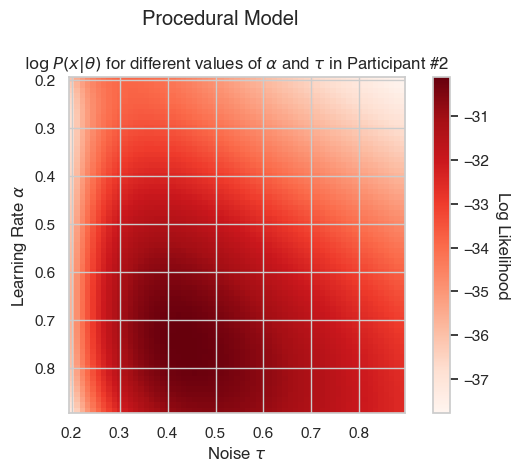

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(matrix2proc, interpolation='nearest', cmap="Reds")
cbar = fig.colorbar(cax)
cbar.set_label("Log Likelihood", rotation=270, labelpad=15)

ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel(r"Learning Rate $\alpha$")
ax.set_xlabel(r"Noise $\tau$")
ax.set_title(r"$\log P(x | \theta)$ for different values of $\alpha$ and $\tau$ in Participant #2")
plt.suptitle("Procedural Model")
plt.tight_layout()
plt.savefig("paramspace_tbt_sub1_proc.png")
plt.show()

In [78]:
intermediates2proc = []
def vtrialbytrialLL2proc(array):
    """Vector function of data"""
    global sub2
    alpha, temp = array
    intermediates2proc.append([alpha, temp])
    return -1 * tbtLLproc(sub2, alpha, temp)

intermediates2proc = []
X0 = [np.random.uniform(0.3, 0.7), np.random.uniform(0.2, 0.5)]
fit = opt.minimize(vtrialbytrialLL2proc, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.2, 0.9], [0.2, 0.9]], 
                   options={"xtol":0.1, "ftol" : 0.1, "maxiter" : 5})

print("Iterations")
for i, params in enumerate(intermediates2proc):
    a, n = params
    print("Iteration %d, alpha = %.6f, tau = %.6f" % (i+1, a, n))

Iterations
Iteration 1, alpha = 0.368880, tau = 0.244152
Iteration 2, alpha = 0.467376, tau = 0.244152
Iteration 3, alpha = 0.632624, tau = 0.244152
Iteration 4, alpha = 0.734752, tau = 0.244152
Iteration 5, alpha = 0.768086, tau = 0.244152
Iteration 6, alpha = 0.701419, tau = 0.244152
Iteration 7, alpha = 0.668086, tau = 0.244152
Iteration 8, alpha = 0.701419, tau = 0.467376
Iteration 9, alpha = 0.701419, tau = 0.632624
Iteration 10, alpha = 0.701419, tau = 0.365248
Iteration 11, alpha = 0.701419, tau = 0.434043
Iteration 12, alpha = 0.701419, tau = 0.400710
Iteration 13, alpha = 0.900000, tau = 0.547439
Iteration 14, alpha = 0.523963, tau = 0.332710
Iteration 15, alpha = 0.667597, tau = 0.414729
Iteration 16, alpha = 0.756367, tau = 0.465420
Iteration 17, alpha = 0.744252, tau = 0.458502
Iteration 18, alpha = 0.733168, tau = 0.452172
Iteration 19, alpha = 0.467376, tau = 0.458502
Iteration 20, alpha = 0.632624, tau = 0.458502
Iteration 21, alpha = 0.734752, tau = 0.458502
Iteration 2

The highest log likelihood, alpha = 0.758616, tau = 0.436938, is:

In [85]:
alpha, tau = fit.x
print(fit.x)
tbtLLproc(sub2, alpha, tau)

[0.75866327 0.43999668]


-30.10569350710137

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2324883087.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_72907/2324883087.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])


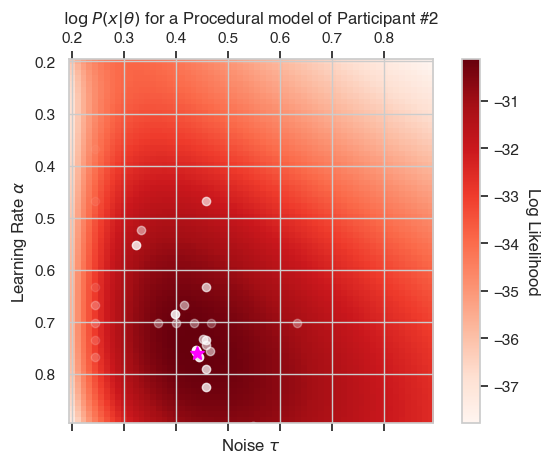

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix2proc, interpolation='nearest', cmap="Reds")
cbar = fig.colorbar(cax)
cbar.set_label("Log Likelihood", rotation=270, labelpad=15)

ax.xaxis.set_major_locator(MultipleLocator(9))
ax.yaxis.set_major_locator(MultipleLocator(9))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in np.linspace(0.2, 0.9, 8)])
ax.set_ylabel(r"Learning Rate $\alpha$")
ax.set_xlabel(r"Noise $\tau$")
ax.set_title(r"$\log P(x | \theta)$ for a Procedural model of Participant #2")
plt.tight_layout()
previous = None
i = 1
N = len(intermediates2proc)

coords =[[(x[0] - 0.2)/0.7 * 63, (x[1] - 0.2)/0.7 * 63] for x in intermediates2proc]

for y, x in coords[:-1]:
    ax.plot(x, y, 'o', color="w", alpha=i/N)
    if previous is not None:
        xp, yp = previous
    
    previous = [x, y]
    i += 1

y, x = coords[-1]
ax.plot(x, y, '*', color="magenta", markersize=10)
plt.autoscale(False)
plt.savefig("powell_tbt_sub2_proc.png")
plt.show()


In [160]:
#dspace = np.linspace(0.2, 0.9, 15)
#nspace = np.linspace(0.2, 0.9, 15)
#matrix = np.zeros((len(dspace), len(nspace)))

#for sub in tqdm(set(alldata.HCPID)): 
#    subN = alldata[alldata.HCPID == sub]
#    for i, d in enumerate(dspace):
#        for j, n in enumerate(nspace):
#            matrix[i,j] = LLdecl2(subN, d, n)
#    plt.matshow(np.exp(matrix), cmap="viridis")
#    plt.title(sub)
#    plt.show()

In [237]:
np.exp(-30.11) / (np.exp(-30.11) + np.exp(-35.65))

0.9960888304738081

Bayes Factors

In [238]:
np.exp(-30.11 + 35.65)

254.6779994585544

random model

In [239]:
64*np.log(1/2)

-44.3614195558365

## A More Complex Declarative Model

This is the model used by Pavlik and Anderson. This model uses a modified version of the activation equation, where every trace has its own specific decay rate $d(i)$:

$$ A_t(c) = \log \sum_i (t – t_i)^{–d(i)}$$

and each decay rate depends, recursively, on the activation of the chunk at the moment the trace was created:

$$ d(i) = \beta e^{A_{t=t(i)}} (c) + \phi $$


In [23]:
def activation2(traces, time, beta, phi):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    phi = max(0, phi)  # Allows no positive decay rates in equation 
    
    trace_times = [ftraces[0]]
    trace_decays = [phi]

    # Compute the trace-specific decay rates 
    for ttime in ftraces[1:]:
        odds = 0.0
        for trace, decay in zip(trace_times, trace_decays):
            odds += (ttime - trace) ** -decay
        trace_times += [ttime]
        trace_decays += [beta * odds + phi]
    
    sumodds = 0.0
    for trace, decay in zip(trace_times, trace_decays):
        sumodds += (time - trace) ** -decay
    
    return np.log(sumodds)
        
    
def trialbytrialLL2(data, beta, phi, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = [2.0, 3.0]
    
    outcomes = [REWARDS[x] for x in REWARDS.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.001] for x in memories]))
    
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation2(DM[opt], time, beta, phi) for opt in options]
        probs = boltzmann(options, values, temp)
        
        if not np.isnan(response):
            # The probability of picking option X is the probability of retrieving a success for X 
            # plus the probability of retrieving a punishment for Y.
            prob1 = probs["%s-%s" % (response, 1.0)]
            other = [x for x in choices if x != response]
            prob2 = probs["%s-%s" % (other[0], -0.5)]
        
        
            # Sum up the LLs
            LL += np.log(max(prob1 + prob2, 10e-10))
        
            # If we have a non-neutral feedback, add a trace
            if REWARDS[feedback] != 0:
                DM["%s-%s" % (response, REWARDS[feedback])] += [time]
        
        if trial % 8 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 32 == 0:
            time += (1 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return LL

Here is an example

In [24]:
trialbytrialLL2(sub2, 0.25, 0.9, 0.25)

-69.60627096942481

In [411]:
intermediates1decl2 = []
def vtrialbytrialLL1decl2(array):
    """Vector function of data"""
    global sub1
    beta, phi, temp = array
    intermediates1decl2.append([beta, phi, temp])
    return -1 * trialbytrialLL2(sub1, beta, phi, temp)

intermediates1decl2 = []
X0 = [np.random.uniform(0.1, 0.3), np.random.uniform(0.2, 0.5), np.random.uniform(0.2, 0.5)]
fit = opt.minimize(vtrialbytrialLL1decl2, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.01, 0.9], [0.01, 0.8], [0.1, 0.9]], 
                   options={"xtol":0.05, "ftol" : 0.05, "maxiter" : 5})

print("Iterations")
for i, params in enumerate(intermediates1decl2):
    b, p, s = params
    print("Iteration %d, beta = %.6f, phi = %.6f,  s = %.6f"% (i+1, b, p, s))

Iterations
Iteration 1, beta = 0.109975, phi = 0.414597,  s = 0.369493
Iteration 2, beta = 0.349950, phi = 0.414597,  s = 0.369493
Iteration 3, beta = 0.560050, phi = 0.414597,  s = 0.369493
Iteration 4, beta = 0.220100, phi = 0.414597,  s = 0.369493
Iteration 5, beta = 0.139849, phi = 0.414597,  s = 0.369493
Iteration 6, beta = 0.090251, phi = 0.414597,  s = 0.369493
Iteration 7, beta = 0.059598, phi = 0.414597,  s = 0.369493
Iteration 8, beta = 0.040653, phi = 0.414597,  s = 0.369493
Iteration 9, beta = 0.040653, phi = 0.311753,  s = 0.369493
Iteration 10, beta = 0.040653, phi = 0.498247,  s = 0.369493
Iteration 11, beta = 0.040653, phi = 0.196494,  s = 0.369493
Iteration 12, beta = 0.040653, phi = 0.125259,  s = 0.369493
Iteration 13, beta = 0.040653, phi = 0.081234,  s = 0.369493
Iteration 14, beta = 0.040653, phi = 0.054025,  s = 0.369493
Iteration 15, beta = 0.040653, phi = 0.037209,  s = 0.369493
Iteration 16, beta = 0.040653, phi = 0.037209,  s = 0.405573
Iteration 17, beta = 0

In [412]:
trialbytrialLL2(sub1, beta=0.87, phi = 0.01,  temp = 0.89)

-45.34619893826028

In [413]:
trialbytrialLL(sub1, decay = 0.21, temp = 0.84)

-47.86606345276423

In [414]:
np.exp(2.52)

12.428596663577544

# Maximum _A Posteriori_

In [51]:
phidist = stat.norm(loc = 0.283, scale = 0.062)
phidist.pdf(0.01) * 0.05

1.9831307857608784e-05

In [30]:

intermediatesMAPdecl2 = []

X0 = [np.random.uniform(0.1, 0.3), np.random.uniform(0.2, 0.5), np.random.uniform(0.2, 0.5)]


def vtrialbytrialMAPdecl2(array):
    """Vector function of data"""
    global sub1
    beta, phi, temp = array
    intermediatesMAPdecl2.append([beta, phi, temp])
    return -1 * (trialbytrialLL2(sub1, beta, phi, temp) + np.log(phidist.pdf(phi)))
                 
                 

fit = opt.minimize(vtrialbytrialMAPdecl2, x0 = X0, 
                   method = "Powell", 
                   bounds=[[0.01, 0.9], [0.01, 0.8], [0.1, 0.9]], 
                   options={"xtol":0.05, "ftol" : 0.05, "maxiter" : 5})

print("Iterations")
for i, params in enumerate(intermediatesMAPdecl2):
    b, p, s = params
    print("Iteration %d, beta = %.6f, phi = %.6f,  s = %.6f"% (i+1, b, p, s))

Iterations
Iteration 1, beta = 0.191603, phi = 0.495106,  s = 0.478903
Iteration 2, beta = 0.349950, phi = 0.495106,  s = 0.478903
Iteration 3, beta = 0.560050, phi = 0.495106,  s = 0.478903
Iteration 4, beta = 0.220100, phi = 0.495106,  s = 0.478903
Iteration 5, beta = 0.139849, phi = 0.495106,  s = 0.478903
Iteration 6, beta = 0.090251, phi = 0.495106,  s = 0.478903
Iteration 7, beta = 0.059598, phi = 0.495106,  s = 0.478903
Iteration 8, beta = 0.040653, phi = 0.495106,  s = 0.478903
Iteration 9, beta = 0.040653, phi = 0.311753,  s = 0.478903
Iteration 10, beta = 0.040653, phi = 0.498247,  s = 0.478903
Iteration 11, beta = 0.040653, phi = 0.196494,  s = 0.478903
Iteration 12, beta = 0.040653, phi = 0.159965,  s = 0.478903
Iteration 13, beta = 0.040653, phi = 0.143298,  s = 0.478903
Iteration 14, beta = 0.040653, phi = 0.176632,  s = 0.478903
Iteration 15, beta = 0.040653, phi = 0.159965,  s = 0.405573
Iteration 16, beta = 0.040653, phi = 0.159965,  s = 0.594427
Iteration 17, beta = 0

In [31]:
trialbytrialLL2(sub1, beta=0.0427, phi = 0.196425,  temp = 0.869)

-47.69270027124408

In [50]:
phidist.pdf(0.19)*0.05

0.10444967392410631

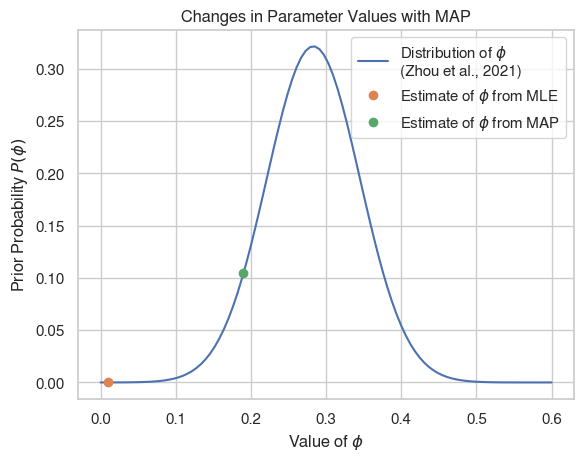

In [60]:
oldphi = 0.01
newphi = 0.19
x = np.linspace(0, 0.6, 100)
y = phidist.pdf(x)  *.05
plt.plot(x, y)
plt.plot(oldphi, phidist.pdf(oldphi) * 0.05, 'o')
plt.plot(newphi, phidist.pdf(newphi) * 0.05, 'o')
plt.legend(["Distribution of $\phi$\n(Zhou et al., 2021)", "Estimate of $\phi$ from MLE", "Estimate of $\phi$ from MAP"])
plt.title("Changes in Parameter Values with MAP")
plt.xlabel("Value of $\phi$")
plt.ylabel("Prior Probability $P(\phi)$")
plt.show()